# EDA and Data Preprocessing/Loading

In [1]:
import torch
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image, ImageOps
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
from skimage import io
from skimage import color
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

/ext3/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ham = pd.read_csv("/vast/amh9750/DL4MED_Project/DL4MED_Data/HAM10000/HAM10000_metadata.csv")
ham

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


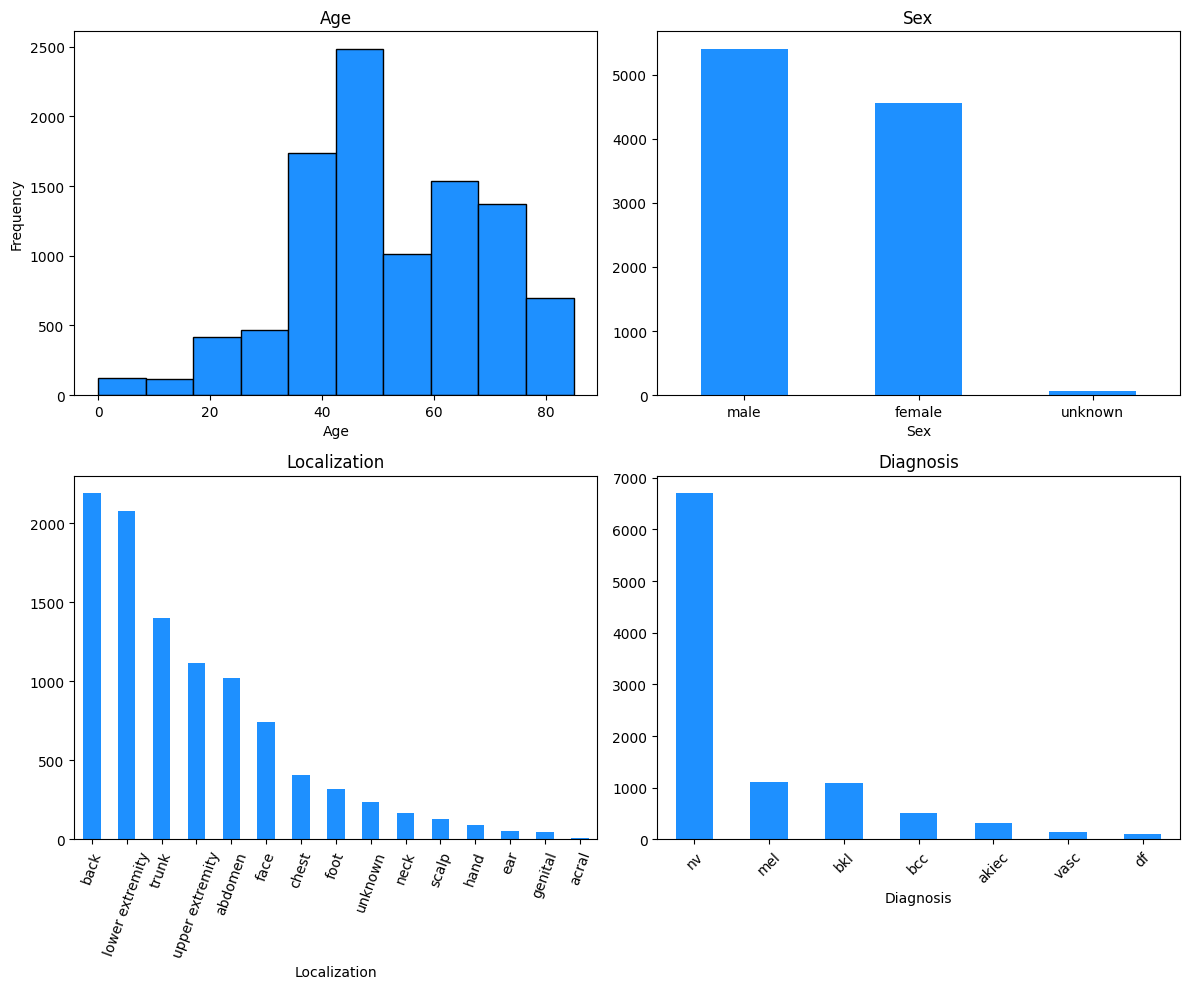

In [3]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(ham['age'], bins=10, edgecolor='black', color='dodgerblue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age')

plt.subplot(2, 2, 2)
ham['sex'].value_counts().plot(kind='bar', color='dodgerblue')
plt.xlabel('Sex')
plt.title('Sex')
plt.xticks(rotation=0)

plt.subplot(2, 2, 3)
ham['localization'].value_counts().plot(kind='bar', color='dodgerblue')
plt.xlabel('Localization')
plt.title('Localization')
plt.xticks(rotation=70)

plt.subplot(2, 2, 4)
ham['dx'].value_counts().plot(kind='bar', color='dodgerblue')
plt.xlabel('Diagnosis')
plt.title('Diagnosis')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [4]:
hiba = pd.read_csv('/vast/amh9750/DL4MED_Project/DL4MED_Data/HIBA/Data/HIBA_dataset.csv')
hiba

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
0,ISIC_6230191,Hospital Italiano de Buenos Aires,CC-BY,25.0,anterior torso,malignant,contact polarized,melanoma,histopathology,NaN,dermoscopic,IL_8124990,IP_8542863,True,640,480,male
1,ISIC_4485929,Hospital Italiano de Buenos Aires,CC-BY,65.0,anterior torso,benign,contact polarized,seborrheic keratosis,NaN,NaN,dermoscopic,IL_1921228,IP_9326183,True,2448,2448,female
2,ISIC_3079785,Hospital Italiano de Buenos Aires,CC-BY,45.0,lower extremity,benign,contact polarized,nevus,histopathology,False,dermoscopic,IL_3797557,IP_4906546,False,640,480,male
3,ISIC_9677008,Hospital Italiano de Buenos Aires,CC-BY,30.0,posterior torso,malignant,contact polarized,melanoma,histopathology,NaN,dermoscopic,IL_3556705,IP_5493434,True,1409,2900,female
4,ISIC_9129115,Hospital Italiano de Buenos Aires,CC-BY,75.0,posterior torso,benign,NaN,actinic keratosis,histopathology,NaN,clinical: overview,IL_2485486,IP_8947694,NaN,498,1026,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,ISIC_6874409,Hospital Italiano de Buenos Aires,CC-BY,75.0,lower extremity,malignant,NaN,basal cell carcinoma,histopathology,NaN,clinical: close-up,IL_7279125,IP_4513580,NaN,1420,1602,female
1612,ISIC_4385084,Hospital Italiano de Buenos Aires,CC-BY,75.0,lower extremity,malignant,contact polarized,basal cell carcinoma,histopathology,NaN,dermoscopic,IL_7279125,IP_4513580,NaN,1738,3574,female
1613,ISIC_9314666,Hospital Italiano de Buenos Aires,CC-BY,55.0,head/neck,benign,contact polarized,actinic keratosis,histopathology,NaN,dermoscopic,IL_1313631,IP_7048742,NaN,1918,933,female
1614,ISIC_8229835,Hospital Italiano de Buenos Aires,CC-BY,65.0,posterior torso,malignant,NaN,basal cell carcinoma,histopathology,NaN,clinical: close-up,IL_9261445,IP_4577038,NaN,457,304,male


In [5]:
hiba_skin_type = pd.read_csv('/vast/amh9750/DL4MED_Project/DL4MED_Data/HIBA/Data/SupplementaryData.csv')
hiba_skin_type

,isic_id,skin_type
0,ISIC_6230191,II
1,ISIC_4485929,I
2,ISIC_3079785,II
3,ISIC_9677008,II
4,ISIC_9129115,II
...,...,...
1611,ISIC_6874409,II
1612,ISIC_4385084,II
1613,ISIC_9314666,II
1614,ISIC_8229835,III


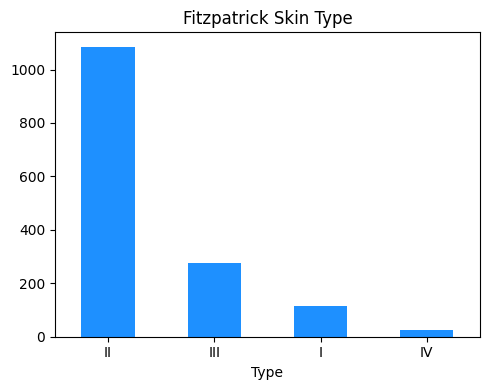

In [6]:
plt.figure(figsize=(5, 4))

hiba_skin_type['skin_type'].value_counts().plot(kind='bar', color='dodgerblue')
plt.xlabel('Type')
plt.title('Fitzpatrick Skin Type')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

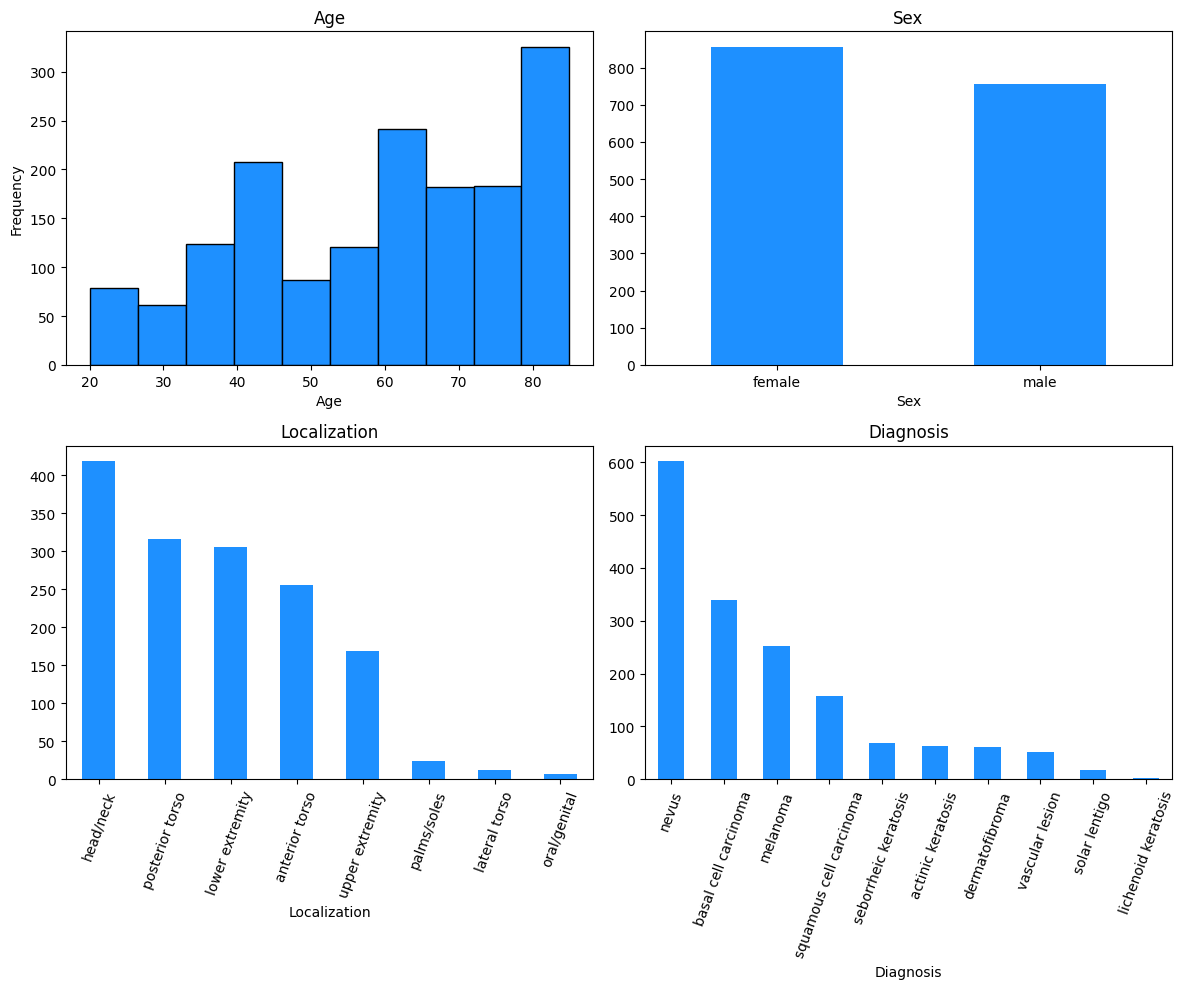

In [7]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(hiba['age_approx'], bins=10, edgecolor='black', color='dodgerblue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age')

plt.subplot(2, 2, 2)
hiba['sex'].value_counts().plot(kind='bar', color='dodgerblue')
plt.xlabel('Sex')
plt.title('Sex')
plt.xticks(rotation=0)

plt.subplot(2, 2, 3)
hiba['anatom_site_general'].value_counts().plot(kind='bar', color='dodgerblue')
plt.xlabel('Localization')
plt.title('Localization')
plt.xticks(rotation=70)

plt.subplot(2, 2, 4)
hiba['diagnosis'].value_counts().plot(kind='bar', color='dodgerblue')
plt.xlabel('Diagnosis')
plt.title('Diagnosis')
plt.xticks(rotation=70)

plt.tight_layout()
plt.show()

### Make Labels Compatible/Mapping Labels

In [8]:
ham['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

`akiec` - Actinic keratoses and intraepithelial carcinoma / Bowen's disease

`bcc` - basal cell carcinoma

`bkl` - benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)

`df` - dermatofibroma

`mel` - melanoma

`nv` - melanocytic nevi

`vasc` - vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)

In [9]:
hiba['diagnosis'].unique()

array(['melanoma', 'seborrheic keratosis', 'nevus', 'actinic keratosis',
       'basal cell carcinoma', 'solar lentigo', 'squamous cell carcinoma',
       'dermatofibroma', 'vascular lesion', 'lichenoid keratosis'],
      dtype=object)

melanoma = `mel`

seborrheic keratosis = `bkl`

nevus = `nv`

actinic keratosis = `akiec`

basal cell carcinoma = `bcc`

solar lentigo = `bkl`

squamous cell carcinoma = `akiec`

dermatofibroma = `df`

vascular lesion = `vasc`

lichenoid keratosis = `bkl`

In [10]:
def class_label(label):
    if label == 'melanoma':
        label = 4
    elif label == 'seborrheic keratosis':
        label = 2
    elif label == 'nevus':
        label = 5
    elif label == 'actinic keratosis':
        label = 0
    elif label == 'basal cell carcinoma':
        label = 1
    elif label == 'solar lentigo':
        label = 2
    elif label == 'squamous cell carcinoma':
        label = 0
    elif label == 'dermatofibroma':
        label = 3
    elif label == 'vascular lesion':
        label = 6
    elif label == 'lichenoid keratosis':
        label = 2
    return label

In [11]:
def class_label(label):
    if label == 'akiec':
        label = 0
    elif label == 'bcc':
        label = 1
    elif label == 'bkl':
        label = 2
    elif label == 'df':
        label = 3
    elif label == 'mel':
        label = 4
    elif label == 'nv':
        label = 5
    elif label == 'vasc':
        label = 6
    return label
        
ham['Class'] = ham['dx'].apply(class_label)

### Make Train/Val/Test 70/10/20 Split Without Data Leakage

In [12]:
groups = ham['lesion_id']

group_splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=47)
train_val_indices, test_indices = next(group_splitter.split(ham, groups=groups))

train_val_data = ham.iloc[train_val_indices]
test_data = ham.iloc[test_indices]

group_splitter = GroupShuffleSplit(n_splits=1, test_size=0.125, random_state=47)
train_indices, val_indices = next(group_splitter.split(train_val_data, groups=train_val_data['lesion_id']))

train_data = train_val_data.iloc[train_indices]
val_data = train_val_data.iloc[val_indices]

In [13]:
total_samples = len(ham)
train_percent = (len(train_data)/total_samples)*100
val_percent = (len(val_data)/total_samples)*100
test_percent = (len(test_data)/total_samples)*100

print('Train set percentage of total data:', train_percent)
print('Validation set percentage of total data:', val_percent)
print('Test set percentage of total data:', test_percent)

print('\nTrain set class distribution:')
print(train_data['Class'].value_counts(normalize=True))
print(train_data['Class'].value_counts(normalize=False))
print('\nValidation set class distribution:')
print(val_data['Class'].value_counts(normalize=True))
print(val_data['Class'].value_counts(normalize=False))
print('\nTest set class distribution:')
print(test_data['Class'].value_counts(normalize=True))
print(test_data['Class'].value_counts(normalize=False))

Train set percentage of total data: 70.22466300549176
Validation set percentage of total data: 9.885172241637544
Test set percentage of total data: 19.890164752870692

Train set class distribution:
Class
5    0.665008
4    0.114460
2    0.110621
1    0.052751
0    0.031850
6    0.013934
3    0.011375
Name: proportion, dtype: float64
Class
5    4677
4     805
2     778
1     371
0     224
6      98
3      80
Name: count, dtype: int64

Validation set class distribution:
Class
5    0.701010
2    0.100000
4    0.097980
1    0.042424
0    0.028283
6    0.016162
3    0.014141
Name: proportion, dtype: float64
Class
5    694
2     99
4     97
1     42
0     28
6     16
3     14
Name: count, dtype: int64

Test set class distribution:
Class
5    0.669679
2    0.111446
4    0.105924
1    0.050703
0    0.037651
6    0.014056
3    0.010542
Name: proportion, dtype: float64
Class
5    1334
2     222
4     211
1     101
0      75
6      28
3      21
Name: count, dtype: int64


In [14]:
train_lesion_ids = set(train_data['lesion_id'])
val_lesion_ids = set(val_data['lesion_id'])
test_lesion_ids = set(test_data['lesion_id'])

overlap_train_val = train_lesion_ids.intersection(val_lesion_ids)
overlap_train_test = train_lesion_ids.intersection(test_lesion_ids)
overlap_val_test = val_lesion_ids.intersection(test_lesion_ids)

if overlap_train_val:
    print("Error: Overlap between train and validation sets:", overlap_train_val)
if overlap_train_test:
    print("Error: Overlap between train and test sets:", overlap_train_test)
if overlap_val_test:
    print("Error: Overlap between validation and test sets:", overlap_val_test)

if not overlap_train_val and not overlap_train_test and not overlap_val_test:
    print("No overlap found. The datasets are properly split.")


No overlap found. The datasets are properly split.


In [23]:
train_data.to_csv('train.csv', index=False)
val_data.to_csv('validation.csv', index=False)
test_data.to_csv('test.csv', index=False)

### Merge Skin Type Information into HIBA CSV and Save

In [15]:
hiba_path = '/vast/amh9750/DL4MED_Project/DL4MED_Data/HIBA/Data/HIBA_dataset.csv'
hiba_df = pd.read_csv(hiba_path)
hiba_skin_type = pd.read_csv('/vast/amh9750/DL4MED_Project/DL4MED_Data/HIBA/Data/SupplementaryData.csv')
hiba_w_skin_type = pd.merge(hiba_df, hiba_skin_type, how='inner', on='isic_id')

In [16]:
hiba_w_skin_type

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,patient_id,personal_hx_mm,pixels_x,pixels_y,sex,skin_type
0,ISIC_6230191,Hospital Italiano de Buenos Aires,CC-BY,25.0,anterior torso,malignant,contact polarized,melanoma,histopathology,NaN,dermoscopic,IL_8124990,IP_8542863,True,640,480,male,II
1,ISIC_4485929,Hospital Italiano de Buenos Aires,CC-BY,65.0,anterior torso,benign,contact polarized,seborrheic keratosis,NaN,NaN,dermoscopic,IL_1921228,IP_9326183,True,2448,2448,female,I
2,ISIC_3079785,Hospital Italiano de Buenos Aires,CC-BY,45.0,lower extremity,benign,contact polarized,nevus,histopathology,False,dermoscopic,IL_3797557,IP_4906546,False,640,480,male,II
3,ISIC_9677008,Hospital Italiano de Buenos Aires,CC-BY,30.0,posterior torso,malignant,contact polarized,melanoma,histopathology,NaN,dermoscopic,IL_3556705,IP_5493434,True,1409,2900,female,II
4,ISIC_9129115,Hospital Italiano de Buenos Aires,CC-BY,75.0,posterior torso,benign,NaN,actinic keratosis,histopathology,NaN,clinical: overview,IL_2485486,IP_8947694,NaN,498,1026,female,II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,ISIC_6874409,Hospital Italiano de Buenos Aires,CC-BY,75.0,lower extremity,malignant,NaN,basal cell carcinoma,histopathology,NaN,clinical: close-up,IL_7279125,IP_4513580,NaN,1420,1602,female,II
1612,ISIC_4385084,Hospital Italiano de Buenos Aires,CC-BY,75.0,lower extremity,malignant,contact polarized,basal cell carcinoma,histopathology,NaN,dermoscopic,IL_7279125,IP_4513580,NaN,1738,3574,female,II
1613,ISIC_9314666,Hospital Italiano de Buenos Aires,CC-BY,55.0,head/neck,benign,contact polarized,actinic keratosis,histopathology,NaN,dermoscopic,IL_1313631,IP_7048742,NaN,1918,933,female,II
1614,ISIC_8229835,Hospital Italiano de Buenos Aires,CC-BY,65.0,posterior torso,malignant,NaN,basal cell carcinoma,histopathology,NaN,clinical: close-up,IL_9261445,IP_4577038,NaN,457,304,male,III


In [17]:
hiba_w_skin_type.count()

isic_id                   1616
attribution               1616
copyright_license         1616
age_approx                1611
anatom_site_general       1506
benign_malignant          1616
dermoscopic_type          1270
diagnosis                 1616
diagnosis_confirm_type    1038
family_hx_mm               759
image_type                1616
lesion_id                 1616
patient_id                1616
personal_hx_mm             885
pixels_x                  1616
pixels_y                  1616
sex                       1611
skin_type                 1499
dtype: int64

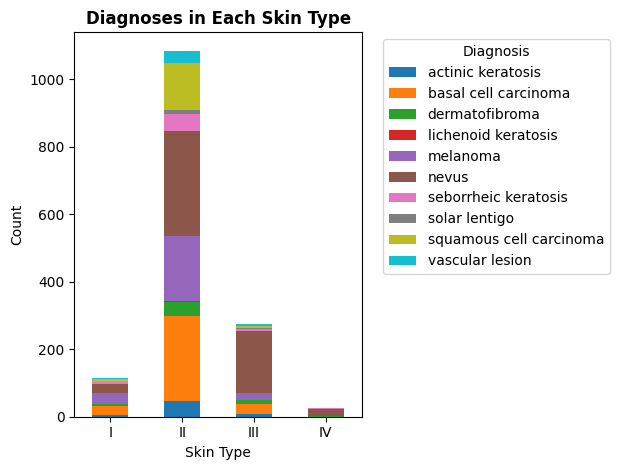

In [40]:
grouped = hiba_w_skin_type.groupby(['skin_type', 'diagnosis']).size().unstack(fill_value=0)

grouped.plot(kind='bar', stacked=True)
plt.title('Diagnoses in Each Skin Type', fontweight='bold')
plt.xlabel('Skin Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('multiclass_diganosis.png')
plt.show()

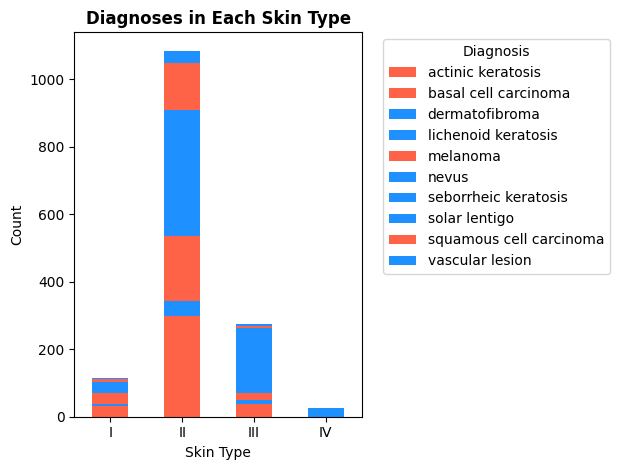

In [39]:
custom_colors = {
    'actinic keratosis': 'tomato',
    'basal cell carcinoma': 'tomato',
    'dermatofibroma': 'dodgerblue',
    'lichenoid keratosis': 'dodgerblue',
    'melanoma': 'tomato',
    'nevus': 'dodgerblue',
    'seborrheic keratosis': 'dodgerblue',
    'solar lentigo': 'dodgerblue',
    'squamous cell carcinoma': 'tomato',
    'vascular lesion': 'dodgerblue'
}
grouped = hiba_w_skin_type.groupby(['skin_type', 'diagnosis']).size().unstack(fill_value=0)

grouped.plot(kind='bar', stacked=True, color=[custom_colors.get(diagnosis, 'gray') for diagnosis in grouped.columns])

plt.title('Diagnoses in Each Skin Type', fontweight='bold')
plt.xlabel('Skin Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('binary_diganosis.png')
plt.show()

In [20]:
display(grouped)

diagnosis,actinic keratosis,basal cell carcinoma,dermatofibroma,lichenoid keratosis,melanoma,nevus,seborrheic keratosis,solar lentigo,squamous cell carcinoma,vascular lesion
skin_type,,,,,,,,,,
I,4,29,4,0,32,27,7,1,8,2
II,47,252,42,2,192,311,50,13,140,36
III,8,31,11,0,19,186,6,3,6,5
IV,0,0,1,0,0,23,1,0,0,0


In [21]:
hiba_w_skin_type.to_csv('HIBA_dataset_skin_type.csv')